In [1]:
import sys
import platform 
system = platform.system()
if system == 'Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis')
    sys.path.append('/home/lucas/src/sysid/')
elif system == 'Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
import sysid
import matplotlib.pyplot as plt
import analog
import numpy as np
import math
from numpy.linalg import inv as inv

In [2]:
if platform.system() == 'Linux':
#     folder = '/home/lucas/Documents/Log_Analysis/Logs/Jack Sparrow (Luigi) z0=1'
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both'
if platform.system() == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/Jack Sparrow (Luigi) z0=1'

In [3]:
# t,u,y = analog.logextract_multi(folder)
# u = np.reshape(u,(len(u),1))
# print(np.shape(u))
# y = np.reshape(y,(len(y),1))
# print(np.shape(y))

In [4]:
log_file = analog.pathfromQGC(folder,index=173)

print(log_file)
info = analog.logextract(log_file,['battery_status','battery_status_ekf','vehicle_local_position'])
print(info.keys())

# From battery_status
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
time = info['time_bs']
time_ekf = info['time_bkf']
n_cells = info['n_cells']
voltage = info['battery_voltage']/n_cells
# From battery_status_ekf
voltage_ekf = info['voltage_ekf']/n_cells[:-1]
voltage_estimate = info['voltage_estimate']
SOC_ekf = info['remaining_ekf']
kalman_gain = info['kalman_gain']
kalman_gain = np.squeeze(kalman_gain)
covar_x = info['covx']
covar_w = info['covw']
innovation = info['innovation']
iR1 = info['iR1']

# discard timestamps with non-initalized battery
current = current[voltage>0]
current_filtered = current_filtered[voltage>0]
SOC = SOC[voltage>0]
time = time[voltage>0]
# kalman_gain = kalman_gain[:,voltage>0]
# covar_x = covar_x[:,:,voltage>0]
# innovation = innovation[voltage>0]
# iR1 = iR1[voltage>0]
voltage = voltage[voltage>0] # to be done at the end
print(len(time))

/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both/log_173_2019-12-19-10-15-02.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'time_bkf', 'remaining_ekf', 'voltage_estimate', 'covx', 'covw', 'kalman_gain', 'innovation', 'iR1', 'voltage_ekf', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining'])
17085


In [5]:
t = time
u = current
y = voltage
i = 5

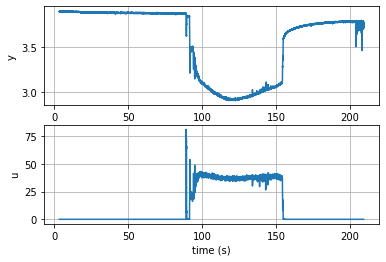

In [6]:
plt.figure()
plt.subplot(211)
plt.plot(t,y)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('y')

plt.subplot(212)
plt.plot(t,u)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('u')
#plt.axvline(t[twoi+N-1],color='r')
plt.show()

In [7]:
battery_id = sysid.subspace_det_algo1(y=y.T,u=u.T,f=i,p=i,s_tol=1e-3,dt=np.mean(np.diff(time)))

(10, 17075)


In [19]:
def f_u(t,x,i):
    return u[i]

In [23]:
print(np.shape(battery_id.A))
print(np.shape(battery_id.C))
print(np.shape(battery_id.D))
print(y[0])
print(battery_id.C)

(2, 2)
(1, 2)
(1, 1)
3.897399663925171
[[-14.55424426  -1.0035687 ]]


In [24]:
w,v = np.linalg.eig(battery_id.A)
print(f'lambda1 = {w[0]}, lambda2 = {w[1]}')
print(np.linalg.det(v))

lambda1 = 1.0000030947643244, lambda2 = 2.0796388390118845
0.9992098543004555


In [25]:
x0prime = np.array([[1.0],[0.0]])
P=-1.19*v
print(inv(P)@battery_id.A@P)
x0 = inv(P)@x0prime
y0 = battery_id.C@x0 + battery_id.D*u[0]
# x0 = np.reshape(np.array([4.25/battery_id.C[0,0],0.0]),(2,1))
print(y0)
print(y[0])

[[ 1.00000309e+00  1.38777878e-17]
 [-1.38777878e-17  2.07963884e+00]]
[[-12.1817489]]
3.897399663925171


In [26]:
print(len(u))
print(len(t))
print(17085*np.mean(np.diff(t)))
print(t[-1])
print(t[0])

17085
17085
205.7632675040974
209.175723
3.424499


In [27]:
data_id = battery_id.simulate(f_u=f_u, x0=x0, tf=t[-1]-t[0])

In [58]:
print(data_id.t[0,-1])
print(t[-1])
print((np.isnan(data_id.y)).any())

205.7391804958621
209.175723
True


<IPython.core.display.Javascript object>


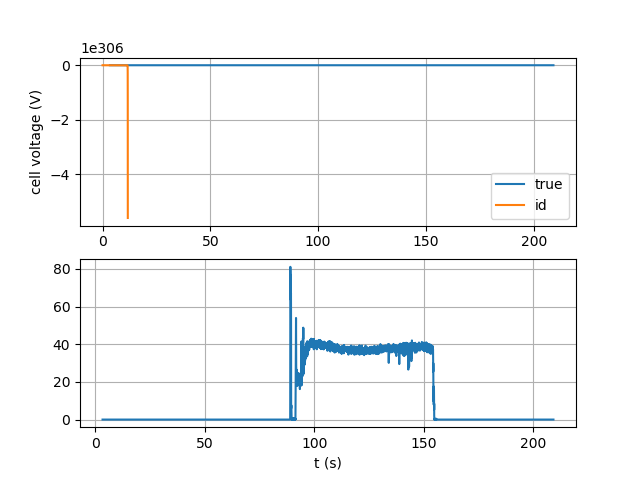

In [54]:
%matplotlib notebook
plt.figure()
plt.subplot(211)
plt.plot(t,y,label='true')
plt.plot(data_id.t.T,data_id.y.T,label='id')
plt.legend()
plt.grid()
plt.ylabel('cell voltage (V)')

plt.subplot(212)
plt.plot(t,u)
plt.xlabel('t (s)')
plt.grid()

In [31]:
R0 = -battery_id.D[0,0]
R1 = -battery_id.C[0,1]
dt = np.mean(np.diff(t))
C1 = -1/math.log(w[1])*dt/R1
print(f'R0 = {R0}, R1 = {R1}, C1 = {C1}')

R0 = 0.002686945101903068, R1 = 1.0035686981282903, C1 = -0.016390018644022338
